In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader

from tqdm import tqdm
import os
import json
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt

#my imports
from models.CNN import CNN
from models.ResNet import ResNet18, create_model
from utils.connectivity import linear_interpolated_model, evaluate_loss
from utils.utils import get_data_loaders
from find_permutation import res_permute

# Linear Mode Connectivity

In [2]:
model_1_path = "logs/vanilla_1/final_model.pt"
model_2_path = "logs/vflip_1/final_model.pt"

experiment_name = "exp_7"

num_steps = 10

data_config = {
  "dataset": "CIFAR10",
  "data_root": "./data/",
  "batch_size": 256,
  "data_augmentation": "vanilla",
  "augment_test":True
}

In [3]:
train_loader, test_loader = get_data_loaders(data_config)

criterion = F.cross_entropy

device = "cuda" if torch.cuda.is_available() else "cpu"

Augmenting test data.
no data augmentation applied
Files already downloaded and verified
Files already downloaded and verified


In [4]:

#create small dataset
idx = torch.randperm(len(train_loader.dataset))[:5000]
small_subset = Subset(train_loader.dataset, idx)

small_train_loader = DataLoader(small_subset,batch_size=data_config["batch_size"], shuffle=True)

#create small test dataset
idx = torch.randperm(len(test_loader.dataset))[:5000]
small_subset = Subset(test_loader.dataset, idx)

small_test_loader = DataLoader(small_subset,batch_size=data_config["batch_size"], shuffle=True)

In [ ]:
config = {
    "num_samples" : 10,
    "iters": 90
}

In [ ]:
#load the models
model_1 = ResNet18()
model_2 = ResNet18()

model_1.load_state_dict(torch.load(model_1_path))
model_2.load_state_dict(torch.load(model_2_path))

model_1 = model_1.to_normal()
model_2 = model_2.to_normal()

model_sym = res_permute(net_permuted=model_1, net_target=model_2, dataloader=permsmall_train_loader_loader,
                                    n_match_iters=config["iters"])

/tmp/ipykernel_21512/1763358611.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(model_1_path))
/tmp/ipykernel_21512/1763358611.py:6: F

In [ ]:
#Start testing for linear connectivity
alphas = np.linspace(0,1, num_steps)
losses = []
accs = []
for alpha in alphas:
    linear_model = linear_interpolated_model(model_1,model_2,alpha)
    loss, acc = evaluate_loss(linear_model, small_train_loader, small_test_loader, criterion, device)
    losses.append(loss)
    accs.append(acc)

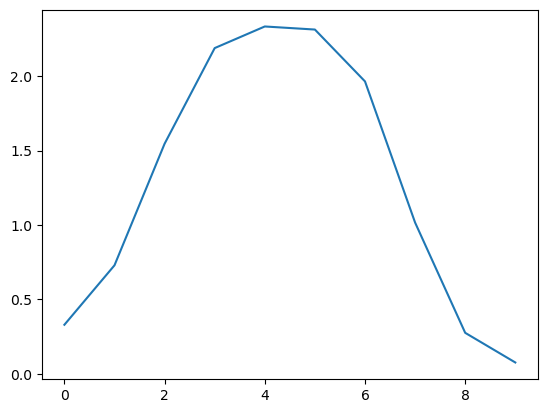

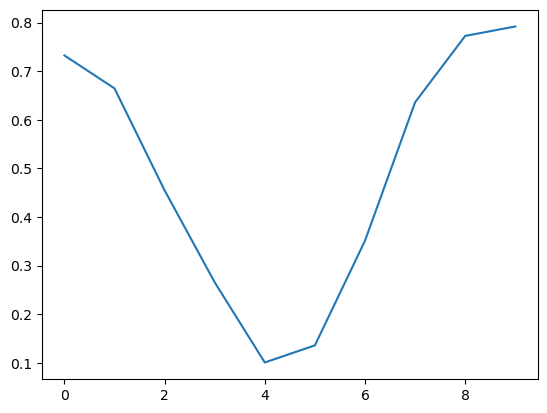

In [6]:
plt.plot(losses)
plt.show()
plt.plot(accs)
plt.show()

results = {
    "losses": losses,
    "accs": accs,
    "model_1": model_1_path,
    "model_2": model_2_path,
}
save_dir = "logs/interpolation/"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, experiment_name)
with open(save_path, "w") as f:
    json.dump(results, f, indent=4)

[[0.2949983894824982, 0.700042799115181, 1.5027632236480712, 2.1396888732910155, 2.3234723091125487, 2.2682294130325316, 1.8826153457164765, 0.9582026362419128, 0.2646514229476452, 0.0750483077019453], [0.5080499857664108, 0.8117012083530426, 1.5490236341953278, 2.152151620388031, 2.3247498631477357, 2.26949942111969, 1.8960003852844238, 1.0326856821775436, 0.4504474952816963, 0.4025859460234642]]


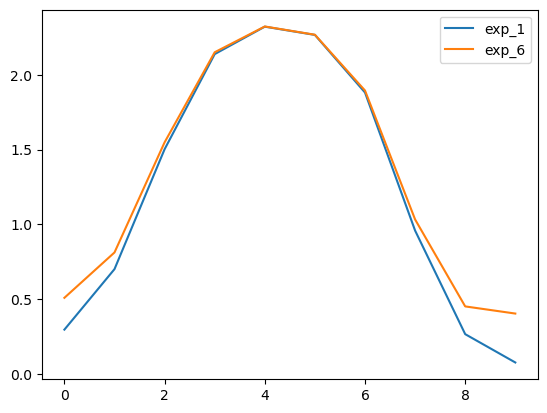

In [7]:
losses = []
experiments = ["exp_1","exp_6"]
for exp in experiments:
    curr_path = os.path.join(save_dir, exp)
    with open(curr_path, "r") as f:
        config = json.load(f)
    losses.append(config["losses"])
print(losses)


for loss, label in zip(losses, experiments):
    plt.plot(loss, label=label)
plt.legend()